<a href="https://colab.research.google.com/github/Shobhit-2510/Modeling-Oxide-Oxidation-Microkinetic-vs-PSS-vs-QE/blob/main/Modeling_Oxide_Oxidation_Microkinetic_vs_PSS_vs_QE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Microkinetic

In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

# Rate constants
k_CO_ads, k_CO_des = 5e3, 1e3
k_O2_ads, k_O2_des = 2e2, 5e2
k3f, k3b = 8e2, 4e2
k_CO2_des, k_CO2_ads = 1e3, 2e1

A = [k_CO_ads, k_CO_des, k_O2_ads, k_O2_des, k3f, k3b, k_CO2_des, k_CO2_ads]

In [ ]:
# Microkinetic ODE
def mkm(t, y, params):
    theta_CO, theta_O, theta_CO2, CO, O2, CO2, theta_V = y
    k_CO_ads, k_CO_des, k_O2_ads, k_O2_des, k3f, k3b, k_CO2_des, k_CO2_ads = params

    r1 = k_CO_ads*CO*theta_V - k_CO_des*theta_CO
    r2 = k_O2_ads*O2*theta_V**2 - k_O2_des*theta_O**2
    r3 = k3f*theta_CO*theta_O - k3b*theta_CO2*theta_V
    r4 = k_CO2_des*theta_CO2 - k_CO2_ads*CO2*theta_V

    dtheta_CO = r1 - r3
    dtheta_O  = 2*r2 - r3
    dtheta_CO2 = r3 - r4
    dCO = -r1
    dO2 = -r2
    dCO2 = r4
    dtheta_V = r4 - r1 - 2*r2

    return [dtheta_CO, dtheta_O, dtheta_CO2, dCO, dO2, dCO2, dtheta_V]

In [ ]:
# Initial conditions & integration
y0 = [0.01, 0.01, 0.01, 0.1, 0.2, 0.0, 0.97]
t_eval = np.linspace(0, 0.03, 500)

sol = solve_ivp(mkm, (0, 5), y0, t_eval=t_eval, method="RK45", args=(A,))
theta_CO, theta_O, theta_CO2, CO, O2, CO2, theta_V = sol.y
rate = k3f*theta_CO*theta_O - k3b*theta_CO2

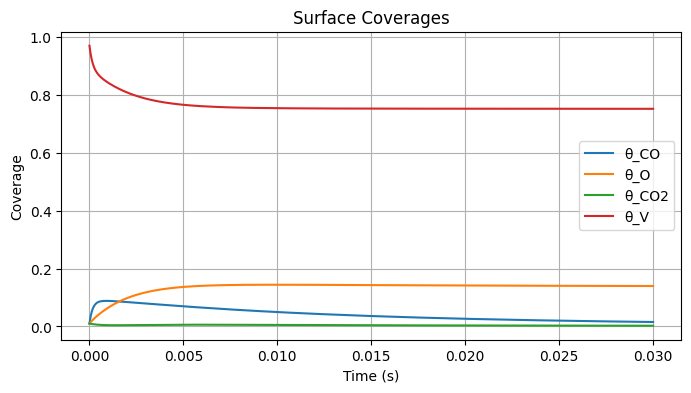

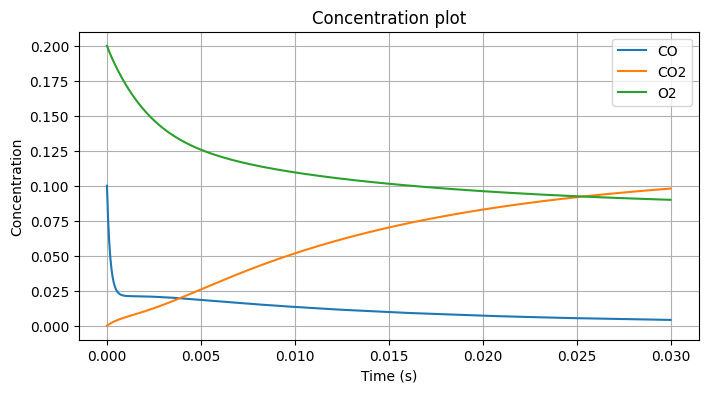

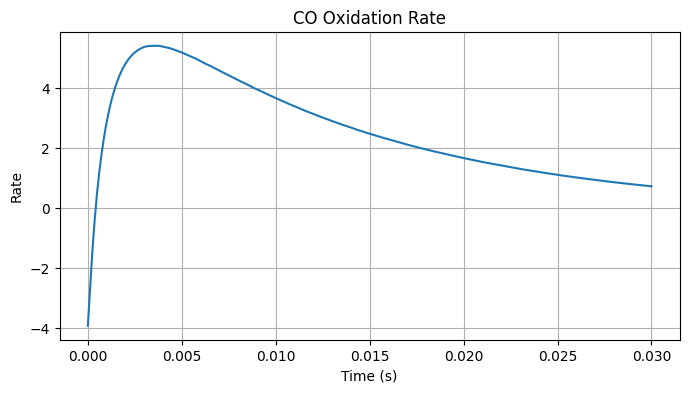

In [ ]:
# Plot coverages and rate
plt.figure(figsize=(8,4))
plt.plot(t_eval, theta_CO, label='θ_CO')
plt.plot(t_eval, theta_O, label='θ_O')
plt.plot(t_eval, theta_CO2, label='θ_CO2')
plt.plot(t_eval, theta_V, label='θ_V')
plt.xlabel('Time (s)'); plt.ylabel('Coverage')
plt.title('Surface Coverages')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,4))
plt.plot(t_eval, CO, label='CO')
plt.plot(t_eval, CO2, label='CO2')
plt.plot(t_eval, O2, label='O2')
plt.xlabel('Time (s)'); plt.ylabel('Concentration')
plt.title('Concentration plot')
plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(8,4))
plt.plot(t_eval, rate)
plt.xlabel('Time (s)'); plt.ylabel('Rate')
plt.title('CO Oxidation Rate')
plt.grid(True); plt.show()


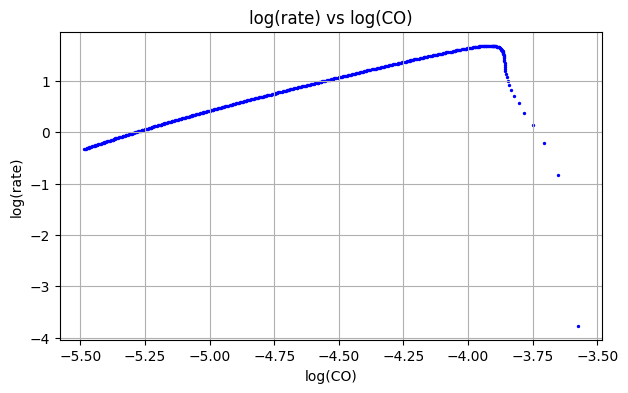

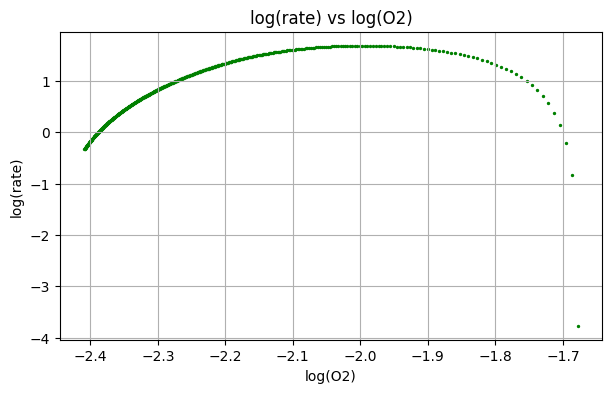

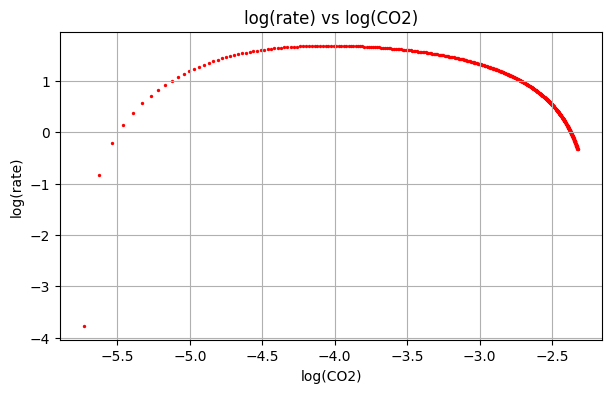

In [ ]:
# Reaction order plots
mask_CO = (CO>0) & (rate>0)
mask_O2 = (O2>0) & (rate>0)
mask_CO2 = (CO2>0) & (rate>0)

plt.figure(figsize=(7,4))
plt.scatter(np.log(CO[mask_CO]), np.log(rate[mask_CO]), color='blue', s=2)
plt.xlabel('log(CO)'); plt.ylabel('log(rate)'); plt.title('log(rate) vs log(CO)'); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.scatter(np.log(O2[mask_O2]), np.log(rate[mask_O2]), color='green', s=2)
plt.xlabel('log(O2)'); plt.ylabel('log(rate)'); plt.title('log(rate) vs log(O2)'); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.scatter(np.log(CO2[mask_CO2]), np.log(rate[mask_CO2]), color='red', s=2)
plt.xlabel('log(CO2)'); plt.ylabel('log(rate)'); plt.title('log(rate) vs log(CO2)'); plt.grid(True); plt.show()


# PSSA

In [ ]:
from scipy.optimize import fsolve

# rate constants
params = A

# Solve surface PSSA
def surface_pssa(CO, O2, CO2, p):
    k1f,k1b,k2f,k2b,k3f,k3b,k4f,k4b = p
    def eqs(v):  # [thetaCO, thetaO, thetaCO2]
        thCO, thO, thCO2 = v
        thV = 1-thCO-thO-thCO2
        r1 = k1f*CO*thV - k1b*thCO
        r2 = k2f*O2*thV**2 - k2b*thO**2
        r3 = k3f*thCO*thO - k3b*thCO2*thV
        r4 = k4f*thCO2 - k4b*CO2*thV
        return [r1-r3, 2*r2-r3, r3-r4]
    thCO, thO, thCO2 = fsolve(eqs, [0.1,0.1,0.01])
    return thCO, thO, thCO2, 1-thCO-thO-thCO2

# ODEs
def odes(t, y, p):
    CO, O2, CO2 = y
    thCO, thO, thCO2, thV = surface_pssa(CO,O2,CO2,p)
    r1 = p[0]*CO*thV - p[1]*thCO
    r2 = p[2]*O2*thV**2 - p[3]*thO**2
    r4 = p[6]*thCO2 - p[7]*CO2*thV
    return [-r1, -r2, r4]

In [ ]:
# Integration
y0 = [0.1,0.2,0.0]
t_eval = np.linspace(0,0.03,400)
sol = solve_ivp(odes, [0,0.03], y0, t_eval=t_eval, method="RK45", args=(params,))
CO, O2, CO2 = sol.y

# Surface coverages & rate
rate, thCO_list, thO_list, thCO2_list, thV_list = [], [], [], [], []
for i in range(len(t_eval)):
    thCO, thO, thCO2, thV = surface_pssa(CO[i], O2[i], CO2[i], params)
    rate.append(params[4]*thCO*thO - params[5]*thCO2*thV)
    thCO_list.append(thCO); thO_list.append(thO); thCO2_list.append(thCO2); thV_list.append(thV)
rate = np.array(rate)

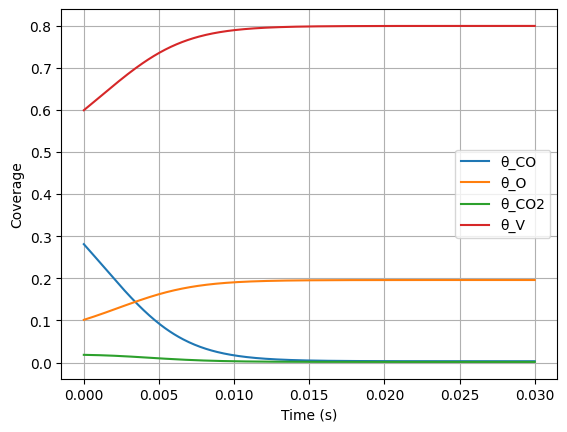

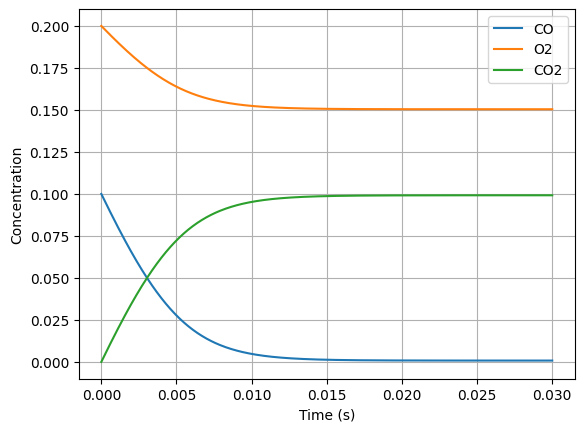

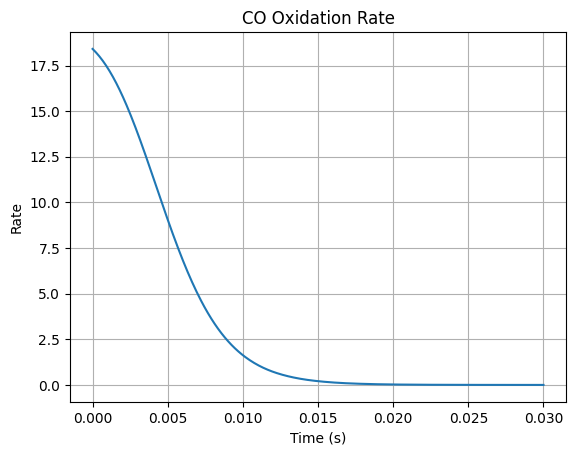

In [ ]:
# Plot coverages, concentration and rate
plt.figure()
plt.plot(t_eval, thCO_list, label='θ_CO'); plt.plot(t_eval, thO_list, label='θ_O')
plt.plot(t_eval, thCO2_list, label='θ_CO2'); plt.plot(t_eval, thV_list, label='θ_V')
plt.xlabel('Time (s)'); plt.ylabel('Coverage'); plt.legend(); plt.grid(True); plt.show()

plt.plot(t_eval, CO, label='CO'); plt.plot(t_eval, O2, label='O2'); plt.plot(t_eval, CO2, label='CO2')
plt.xlabel('Time (s)'); plt.ylabel('Concentration'); plt.legend(); plt.grid(True); plt.show()

plt.figure()
plt.plot(t_eval, rate); plt.xlabel('Time (s)'); plt.ylabel('Rate'); plt.title('CO Oxidation Rate'); plt.grid(True); plt.show()

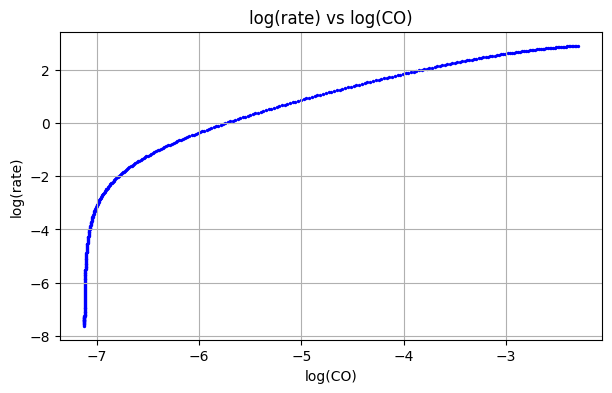

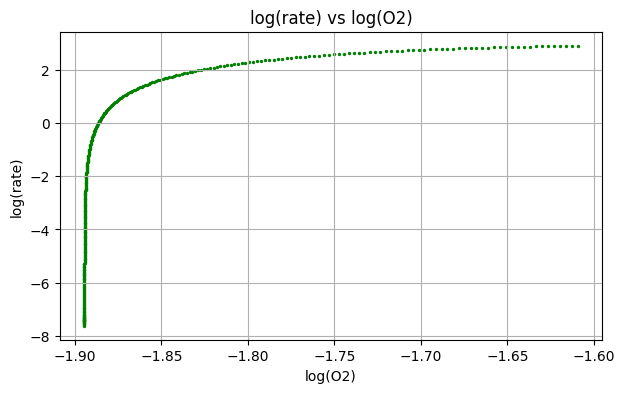

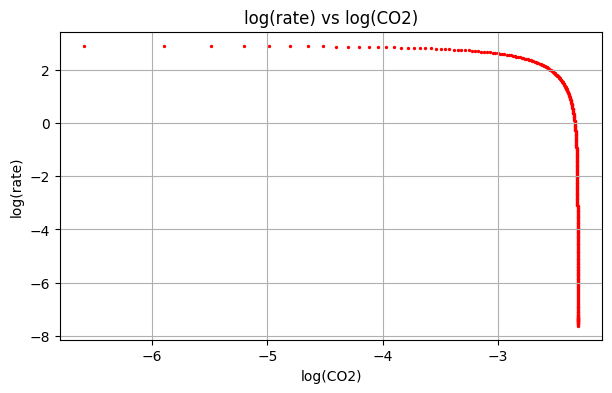

In [ ]:
# Reaction order plots
mask_CO = (CO>0) & (rate>0)
mask_O2 = (O2>0) & (rate>0)
mask_CO2 = (CO2>0) & (rate>0)

plt.figure(figsize=(7,4))
plt.scatter(np.log(CO[mask_CO]), np.log(rate[mask_CO]), color='blue', s=2)
plt.xlabel('log(CO)'); plt.ylabel('log(rate)'); plt.title('log(rate) vs log(CO)'); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.scatter(np.log(O2[mask_O2]), np.log(rate[mask_O2]), color='green', s=2)
plt.xlabel('log(O2)'); plt.ylabel('log(rate)'); plt.title('log(rate) vs log(O2)'); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.scatter(np.log(CO2[mask_CO2]), np.log(rate[mask_CO2]), color='red', s=2)
plt.xlabel('log(CO2)'); plt.ylabel('log(rate)'); plt.title('log(rate) vs log(CO2)'); plt.grid(True); plt.show()


# QE

In [ ]:
K1, K2, K4 = k_CO_ads/k_CO_des, k_O2_ads/k_O2_des, k_CO2_ads/k_CO2_des
params = (K1, K2, K4, k3f, k3b)

# Compute coverages from QE
def coverages(CO, O2, CO2, K1, K2, K4):
    theta_V = 1 / (1 + K1*CO + np.sqrt(K2*O2) + K4*CO2)
    theta_CO  = K1 * CO * theta_V
    theta_O   = np.sqrt(K2 * O2) * theta_V
    theta_CO2 = K4 * CO2 * theta_V
    return theta_CO, theta_O, theta_CO2, theta_V
# ODEs
def odes(t, y, params):
    CO, O2, CO2 = y
    K1, K2, K4, k3f, k3b = params
    thCO, thO, thCO2, thV = coverages(CO, O2, CO2, K1, K2, K4)
    r3 = k3f*thCO*thO - k3b*thCO2*thV
    return [-r3, -0.5*r3, r3]

In [ ]:
# Integrate
y0 = [0.1, 0.2, 0.0]             # Initial concentrations
t_eval = np.linspace(0, 0.03, 400)
sol = solve_ivp(odes, [0,0.03], y0, t_eval=t_eval, args=(params,), method="RK45")
CO, O2, CO2 = sol.y

# rate and coverages
r3 = np.array([k3f*coverages(c,o,co2,K1,K2,K4)[0]*coverages(c,o,co2,K1,K2,K4)[1] -
               k3b*coverages(c,o,co2,K1,K2,K4)[2]*coverages(c,o,co2,K1,K2,K4)[3]
               for c,o,co2 in zip(CO,O2,CO2)])

theta_CO, theta_O, theta_CO2, theta_V = zip(*[coverages(c,o,co2,K1,K2,K4) for c,o,co2 in zip(CO,O2,CO2)])

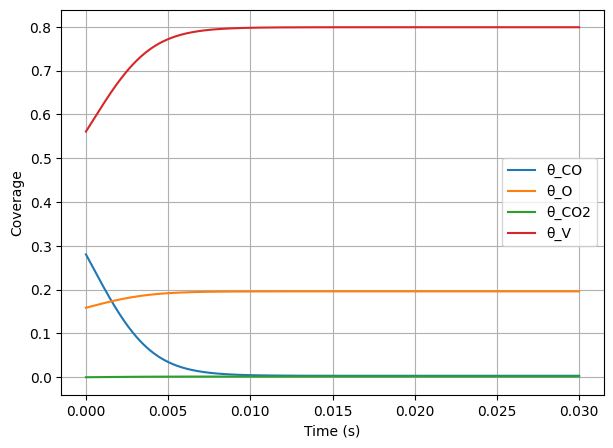

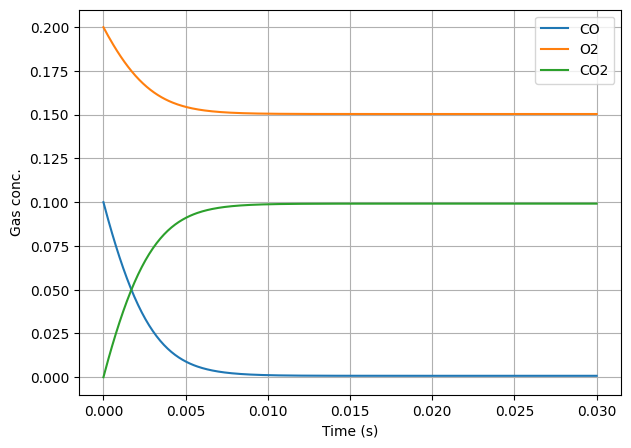

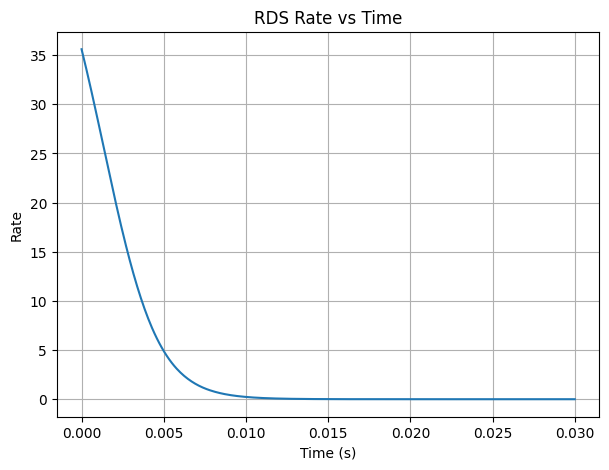

In [ ]:
# Plots
plt.figure(figsize=(7,5))
plt.plot(t_eval, theta_CO, label='θ_CO')
plt.plot(t_eval, theta_O, label='θ_O')
plt.plot(t_eval, theta_CO2, label='θ_CO2')
plt.plot(t_eval, theta_V, label='θ_V')
plt.xlabel('Time (s)'); plt.ylabel('Coverage'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.plot(t_eval, CO, label='CO'); plt.plot(t_eval, O2, label='O2'); plt.plot(t_eval, CO2, label='CO2')
plt.xlabel('Time (s)'); plt.ylabel('Gas conc.'); plt.legend(); plt.grid(True); plt.show()

plt.figure(figsize=(7,5))
plt.plot(t_eval, r3); plt.xlabel('Time (s)'); plt.ylabel('Rate'); plt.title('RDS Rate vs Time'); plt.grid(True); plt.show()

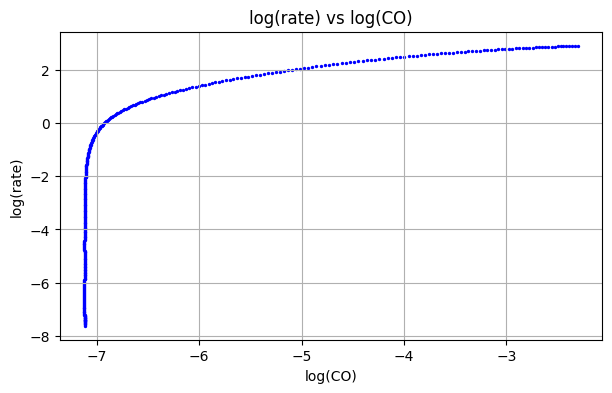

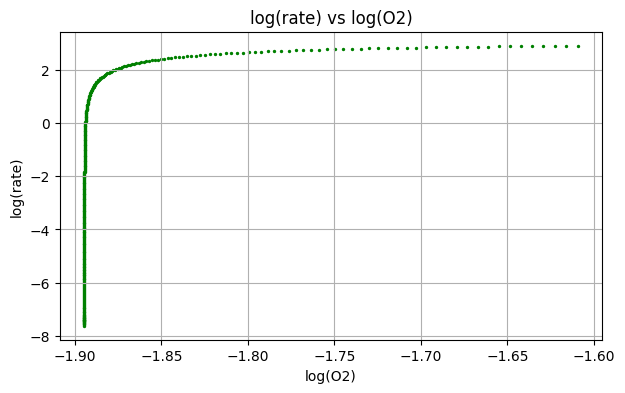

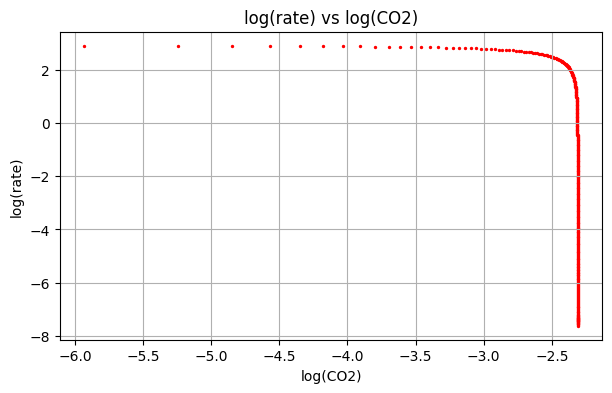

In [ ]:
# Reaction order (log-log)
mask_CO = (CO>0) & (rate>0)
mask_O2 = (O2>0) & (rate>0)
mask_CO2 = (CO2>0) & (rate>0)

plt.figure(figsize=(7,4))
plt.scatter(np.log(CO[mask_CO]), np.log(rate[mask_CO]), color='blue', s=2)
plt.xlabel('log(CO)'); plt.ylabel('log(rate)'); plt.title('log(rate) vs log(CO)'); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.scatter(np.log(O2[mask_O2]), np.log(rate[mask_O2]), color='green', s=2)
plt.xlabel('log(O2)'); plt.ylabel('log(rate)'); plt.title('log(rate) vs log(O2)'); plt.grid(True); plt.show()

plt.figure(figsize=(7,4))
plt.scatter(np.log(CO2[mask_CO2]), np.log(rate[mask_CO2]), color='red', s=2)
plt.xlabel('log(CO2)'); plt.ylabel('log(rate)'); plt.title('log(rate) vs log(CO2)'); plt.grid(True); plt.show()
